### 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn import tree
from sklearn import preprocessing

### 문제 정의
- 유전체 정보(SNP)를 통해 품종 분류 예측 모델을 생성.

In [2]:
train = pd.read_csv('open/train.csv')
test = pd.read_csv('open/test.csv')

### 데이터 전처리

In [20]:
# 분별력이 없는 특징(feature)을 데이터에서 제거.
#df.drop(['id', 'father', 'mother', 'gender'], axis=1, inplace=True)
#df.head()

def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id'])
        return df_x

In [21]:
train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

In [22]:
class_le = preprocessing.LabelEncoder()
snp_le = preprocessing.LabelEncoder()
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]

In [23]:
snp_data = []
for col in snp_col:
    snp_data += list(train_x[col].values)

In [24]:
train_y = class_le.fit_transform(train_y)
snp_le.fit(snp_data)

LabelEncoder()

In [25]:
for col in train_x.columns:
    if col in snp_col:
        train_x[col] = snp_le.transform(train_x[col])
        test_x[col] = snp_le.transform(test_x[col])

### 데이터 나누기(학습 데이터, 테스트 데이터)

In [26]:
tr_train, tr_test = train_test_split(train_x, test_size=0.2)

In [27]:
print(tr_train.shape[0])
print(tr_test.shape[0])

In [28]:
tr_train.to_csv("open/eda_tr_train.csv", index = None)

In [29]:
tr_test.to_csv("open/eda_tr_test.csv", index = None)

### 데이터 불러오기(학습 데이터, 테스트 데이터)

In [30]:
train_tr = pd.read_csv("open/eda_tr_train.csv")
test_tr = pd.read_csv("open/eda_tr_test.csv")

In [31]:
print(train_tr.shape[0]) # 훈련용 데이터 셋 갯수
print(train_tr.shape[1]) # feature 갯수

print(test_tr.shape[0]) # 테스트 데이터 셋 갯수
print(test_tr.shape[1]) # feature 셋 갯수

### 최적의 k 찾기

In [32]:
# 최적의 k 찾기. 3부터 시작해서 max_k_range / 2 까지의 범위.
max_k_range = train.shape[0] // 2
k_list = []

for i in range(3, max_k_range, 2): # 3, 5, .... 39
    k_list.append(i)
    
cross_validation_scores = []
x_train = train_x[snp_col]
y_train = train_y

In [36]:
# 10-fold cross validation(k-fold 검증)
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=15, scoring='accuracy')
    cross_validation_scores.append(scores.mean())
    
cross_validation_scores

[0.92008547008547,
 0.9047008547008547,
 0.9121082621082621,
 0.9237891737891738,
 0.9237891737891738,
 0.9162393162393163,
 0.9123931623931624,
 0.9085470085470085,
 0.9198005698005698,
 0.9162393162393163,
 0.9200854700854701,
 0.9125356125356126,
 0.9086894586894587,
 0.9125356125356126,
 0.9162393162393162,
 0.9162393162393162,
 0.9162393162393162,
 0.9162393162393162,
 0.923931623931624,
 0.9202279202279202,
 0.9202279202279202,
 0.9163817663817664,
 0.9085470085470085,
 0.9085470085470085,
 0.900997150997151,
 0.8856125356125355,
 0.8893162393162392,
 0.8894586894586893,
 0.8856125356125355,
 0.8856125356125355,
 0.8856125356125355,
 0.8893162393162392,
 0.8856125356125355,
 0.8856125356125355,
 0.8854700854700855,
 0.8779202279202278,
 0.874074074074074,
 0.8665242165242164,
 0.8665242165242164,
 0.8665242165242164,
 0.8626780626780626,
 0.8626780626780626,
 0.8626780626780626,
 0.8626780626780626,
 0.8588319088319087,
 0.8551282051282051,
 0.8475783475783475,
 0.847578347578347

ValueError: x and y must have same first dimension, but have shapes (64,) and (128,)

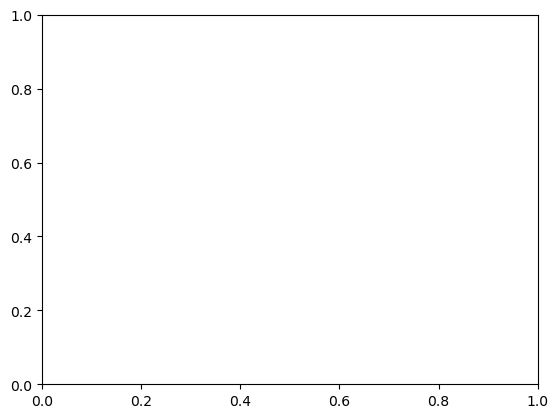

In [39]:
# 시각화
plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('Accuracy')
plt.show()

In [35]:
# 최적의 K 값
cvs = cross_validation_scores
k = k_list[cvs.index(max(cross_validation_scores))]
print("최적의 k 값 : " + str(k))

최적의 k 값 : 39


### 2개의 특징으로 예측하기('trait', 'SNP_01')

In [19]:
## 앞서 진행한 스킴을 통해 찾은 최적의 k값으로 학습을 진행!
knn = KNeighborsClassifier(n_neighbors=k)

x_train = train[['trait', 'SNP_01']]
y_train = train[['class']]

## 학습을 시켜야 모델이 생성된다! : fit()으로 학습을 시킴!
knn.fit(x_train, y_train.values.ravel())

x_test = test[['trait', 'SNP_01']]
y_test = test[['class']] ## 결과를 2차배열로 가지고 있음. 20 by 1의 형태로.

## 만든 모델의 테스트(검증)을 수행함.
pred = knn.predict(x_test)

ValueError: could not convert string to float: 'G G'

In [ ]:
comparision = pd.DataFrame({'prediction':pred, 'target':y_test.values.ravel()}) ## 2차 배열로 가지고 있던 형태를 1차 배열 형태로 바꾸어 줘야 함!
comparision

## 12행에서 하나가 틀림 : 95% 정도의 정확도로 볼 수 있다.

In [ ]:
## 정확도 계산을 위해 import함.
from sklearn.metrics import accuracy_score

print("accuracy : " + str(accuracy_score(y_test.values.ravel(), pred)))

### 전부 다 가지고 예측하기

In [ ]:
## 앞서 진행한 스킴을 통해 찾은 최적의 k값으로 학습을 진행!
knn = KNeighborsClassifier(n_neighbors=k)

x_train = train[snp_col]
y_train = train[['class']]

## 학습을 시켜야 모델이 생성된다! : fit()으로 학습을 시킴!
knn.fit(x_train, y_train.values.ravel())

x_test = test[snp_col]
y_test = test[['class']] ## 결과를 2차배열로 가지고 있음.

## 만든 모델의 테스트(검증)을 수행함.
pred = knn.predict(x_test)

In [ ]:
comparision = pd.DataFrame({'prediction':pred, 'target':y_test.values.ravel()}) ## 2차 배열로 가지고 있던 형태를 1차 배열 형태로 바꾸어 줘야 함!
comparision

In [ ]:
## 정확도 계산을 위해 import함.
from sklearn.metrics import accuracy_score

print("accuracy : " + str(accuracy_score(y_test.values.ravel(), pred)))

In [ ]:
print(y_train['class'].value_counts())

In [ ]:
print(y_train)

### 테스트 데이터를 가지고 검증해보기

In [ ]:
test = pd.read_csv('open/test.csv')

In [ ]:
print(test)

In [ ]:
# 분별력이 없는 특징(feature)을 데이터에서 제거.
test.drop(['id', 'father', 'mother', 'gender'], axis=1, inplace=True)
print(test)

In [ ]:
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]
print(snp_col)

In [ ]:
le = preprocessing.LabelEncoder()

snp_data = []
for col in snp_col:
    snp_data += list(test[col].values)

In [ ]:
le.fit(snp_data)

In [ ]:
for col in df.columns:
    if col in snp_col:
        test[col] = le.transform(test[col])

In [ ]:
print(test)

### 먼저 KNN으로 테스트.

In [ ]:
## 앞서 진행한 스킴을 통해 찾은 최적의 k값으로 학습을 진행!
knn = KNeighborsClassifier(n_neighbors=k)

x_train = train[snp_col]
y_train = train[['class']]

## 학습을 시켜야 모델이 생성된다! : fit()으로 학습을 시킴!
knn.fit(x_train, y_train.values.ravel())

x_test = test[snp_col]
y_test = test[['class']] ## 결과를 2차배열로 가지고 있음. 20 by 1의 형태로.

## 만든 모델의 테스트(검증)을 수행함.
pred = knn.predict(x_test)

In [ ]:
comparision = pd.DataFrame({'prediction':pred, 'target':y_test.values.ravel()}) ## 2차 배열로 가지고 있던 형태를 1차 배열 형태로 바꾸어 줘야 함!
comparision

In [ ]:
## 정확도 계산을 위해 import함.
from sklearn.metrics import accuracy_score

print("accuracy : " + str(accuracy_score(y_test.values.ravel(), pred)))

# 랜덤포레스트 적용해보기

### 필요한 라이브러리 임포트

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

np.random.seed(5)

In [ ]:
def cross_validation(classifier, x_train, y_train):
    cv_scores = []
    
    for i in range(10):
        scores = cross_val_score(classifier, x_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    return cv_scores

In [ ]:
df_cv_scores = cross_validation(DecisionTreeClassifier(), x_train, y_train)

In [ ]:
rf_cv_scores = cross_validation(RandomForestClassifier(), x_train, y_train)

### 랜덤포레스트 VS 의사결정트리 시각화

In [ ]:
cv_list = [
            ['random_forest', rf_cv_scores],
            ['decision_tree', df_cv_scores]
           ]

df_a = pd.DataFrame.from_dict(dict(cv_list))

In [ ]:
df_a.plot()

In [ ]:
# 의사결정트리 정확도
np.mean(df_cv_scores)

In [ ]:
# 랜덤포레스트 정확도
np.mean(rf_cv_scores)

In [ ]:
rf_test1 = RandomForestClassifier(random_state=42)
rf_test1.fit(x_train, y_train)

In [ ]:
preds = rf_test1.predict(test)